In [1]:
import shutup
shutup.please()

In [2]:
import os
import time
import numpy as np
import random
from datetime import datetime
from multiprocessing import cpu_count
from threading import Thread, Lock

from src.agents.agent import Agent
from src.utils.buffer import Buffer

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input, Dense, Concatenate, Lambda
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Model

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# from tensorflow.python.framework.ops import disable_eager_execution

# disable_eager_execution()
#tf.compat.v1.disable_eager_execution()

In [3]:
from src.utils.networks import CommonLayer

class ActorNetwork():
    def __init__(self,
                 observation_shape,
                 action_space_mode,
                 action_bound,
                 policy,
                 n_actions, 
                 optimizer=Adam,
                 learning_rate=0.01,
                 std_bound = [1e-2, 1.0],
    ):
        
        self.observation_shape = observation_shape
        self.policy = policy
        self.n_actions = n_actions
        self.action_space_mode = action_space_mode
        self.std_bound=std_bound
        self.action_bound = action_bound
        
        optimizer = optimizer(learning_rate)
        
        
        X_input = Input(shape=self.observation_shape) 
        X = CommonLayer(X_input,self.policy)
        
        if self.action_space_mode == "discrete":
            action = Dense(self.n_actions, activation="softmax", kernel_initializer='he_uniform')(X)
            self.model = Model(inputs = X_input, outputs = action)
            self.model.compile(loss='categorical_crossentropy', optimizer=optimizer)
        else:
            mu = Dense(self.n_actions, activation="tanh", kernel_initializer='he_uniform')(X)
            mu = Lambda(lambda x: x * self.action_bound)(mu)
            sigma = Dense(self.n_actions, activation="softplus", kernel_initializer='he_uniform')(X)
            
            self.model = Model(inputs = X_input, outputs = Concatenate()([mu,sigma]))
            self.model.compile(loss=self.continuous_actor_loss, optimizer=optimizer)
    
    def log_pdf(self,mu, sigma, action):
        std = tf.clip_by_value(sigma, self.std_bound[0], self.std_bound[1])
        var = std ** 2
        log_policy_pdf = -0.5 * (action - mu) ** 2 / var - 0.5 * tf.math.log(
            var * 2 * np.pi
        )
        return tf.reduce_sum(log_policy_pdf, 1, keepdims=True)
    
    def continuous_actor_loss(self, y_true, y_pred):
        actions, advantages = y_true[:, :self.n_actions], y_true[:, self.n_actions:]
        mu,sigma = y_pred[:,:1], y_pred[:,1:]
        log_policy_pdf = self.log_pdf(mu,sigma,actions)
        loss_policy = log_policy_pdf * advantages
        
        return tf.reduce_sum(-loss_policy)
    
    def act(self,state):
        state = np.expand_dims(state, axis=0)
        if self.action_space_mode == "discrete":
            prediction = self.model.predict(state)[0]
            action = np.random.choice(self.n_actions, p=prediction)
            action_onehot = np.zeros([self.n_actions])
            action_onehot[action] = 1
        else:
            prediction = self.model.predict(state)[0]
            mu = prediction[0]
            sigma = prediction[1]
            action = np.random.normal(mu, sigma,self.n_actions)
            action = np.clip(action, -self.action_bound, self.action_bound)
            action_onehot = action
        return action, action_onehot, prediction
    

class CriticNetwork():
    def __init__(self,
                 observation_shape,
                 action_space_mode,
                 policy,
                 n_actions, 
                 optimizer=Adam,
                 learning_rate=0.01,
                 std_bound = [1e-2, 1.0],
    ):

        self.observation_shape = observation_shape
        self.policy = policy
        self.n_actions = n_actions
        self.action_space_mode = action_space_mode
        self.std_bound=std_bound
        
        optimizer = optimizer(learning_rate)
        
        X_input = Input(shape=self.observation_shape) 
        X = CommonLayer(X_input,self.policy)
        
        value = Dense(1, kernel_initializer='he_uniform')(X)
        
        self.model = Model(inputs = X_input, outputs = value)
        self.model.compile(loss='mse', optimizer=optimizer)
    
    
   

In [4]:
import numpy as np

class ReplayBuffer:
    def __init__(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.size = 0

    def reset(self):
        self.size = 0
        self.states.clear()
        self.actions.clear()
        self.rewards.clear()

    def remember(self, state, action_onehot, reward ):
        self.size +=1
        self.states.append(state)
        self.actions.append(action_onehot)
        self.rewards.append(reward)

#     def sample(self, batch_size=64):
#         max_mem = min(self.buffer_counter, self.buffer_size)

#         batch = np.random.choice(max_mem, batch_size)

#         states = self.state_memory[batch]
#         states_ = self.new_state_memory[batch]
#         actions = self.action_memory[batch]
#         rewards = self.reward_memory[batch]
#         dones = self.done_memory[batch]

#         return states, actions, rewards, states_, dones

In [5]:
# GLOBAL_EPISODE_NUM = 0

# class A3CWorker(Thread):
#     def __init__(self, 
#                 worker_id,
#                 env, 
#                 global_actor, 
#                 global_critic, 
#                 action_space_mode,
#                 observation_shape,
#                 policy,
#                 n_actions,
#                 actor_optimizer=RMSprop,
#                 critic_optimizer=RMSprop,
#                 actor_learning_rate=0.001,
#                 critic_learning_rate=0.001,
#                 std_bound = [1e-2, 1.0],
#                 action_bound=False,
#                 batch_size=64):
#         Thread.__init__(self)
        
#         self.worker_id = worker_id
#         self.env = env
#         self.action_space_mode = action_space_mode
#         self.observation_shape = observation_shape
#         self.policy = policy
#         self.n_actions = n_actions
#         self.actor_optimizer = actor_optimizer
#         self.critic_optimizer = critic_optimizer
#         self.actor_learning_rate= actor_learning_rate
#         self.critic_learning_rate=critic_learning_rate
#         self.std_bound = std_bound
#         self.action_bound = action_bound

#         self.global_actor = global_actor
#         self.global_critic = global_critic
#         print('Before init networks')
#         self.__init_networks()
#         self.__init_buffers()

#         print('After init networks')
#         print(global_actor.model)
#         print(self.actor.model)
        
# #         print('Before make predict')
# #         self.actor.model._make_predict_function()
# #         self.critic.model._make_predict_function()
# #         print('After make predict')
        
#         print('Before set weights')
#         self.actor.model.set_weights(self.global_actor.model.get_weights())
#         self.critic.model.set_weights(self.global_critic.model.get_weights())
#         print('After set weights')
        

        
#     def __init_networks(self):
#         self.actor = ActorNetwork(
#             observation_shape=self.observation_shape,
#             action_space_mode=self.action_space_mode,
#             policy=self.policy,
#             n_actions=self.n_actions, 
#             optimizer=self.actor_optimizer,
#             learning_rate=self.actor_learning_rate,
#             std_bound = self.std_bound,
#             action_bound = self.action_bound
#         )
        
#         self.critic = CriticNetwork(
#             observation_shape=self.observation_shape,
#             action_space_mode=self.action_space_mode,
#             policy=self.policy,
#             n_actions=self.n_actions, 
#             optimizer=self.critic_optimizer,
#             learning_rate=self.critic_learning_rate,
#             std_bound = self.std_bound
#         )
    
#     def __init_buffers(self):
#         self.buffer = ReplayBuffer()
        
    
#     def act(self,state):
#         action, action_onehot, prediction = self.actor.act(state)
#         return action, action_onehot, prediction
    
#     def discount_rewards(self, reward):
#         # Compute the gamma-discounted rewards over an episode
#         gamma = 0.99    # discount rate
#         running_add = 0
#         discounted_r = np.zeros_like(reward)
#         for i in reversed(range(0,len(reward))):
#             running_add = running_add * self.gamma + reward[i]
#             discounted_r[i] = running_add

#         discounted_r -= np.mean(discounted_r) # normalizing the result
#         discounted_r /= (np.std(discounted_r) + 1e-8) # divide by standard deviation
        
#         return discounted_r
    
#     def replay(self):
#         print(self.worker_id, 'replay')

#         if self.buffer.size > 1:
#             # reshape memory to appropriate shape for training
#             states = np.vstack(self.buffer.states)
#             actions = np.vstack(self.buffer.actions)

#             # Compute discounted rewards
#             discounted_r = self.discount_rewards(self.buffer.rewards)

#             # Get Critic network predictions
#             values = self.global_critic.model.predict(states)[:, 0]
#             # Compute advantages
#             advantages = discounted_r - values
#             # training Actor and Critic networks


#             if self.action_space_mode == "discrete":
#                 self.global_actor.model.fit(states, actions, sample_weight=advantages, epochs=1, verbose=0)
#             else:
#                 self.global_actor.model.fit(states,np.concatenate([actions,np.reshape(advantages,newshape=(len(advantages),1))],axis=1), epochs=1,verbose=0)

#             self.global_critic.model.fit(states, discounted_r, epochs=1, verbose=0)
            
#             # Reset weights
#             self.actor.model.set_weights(self.global_actor.model.get_weights())
#             self.critic.model.set_weights(
#                 self.global_critic.model.get_weights()
#             )
#             # reset training memory
#             self.buffer.reset()
        

#     def learn(self, timesteps=-1, plot_results=True, reset=False, success_threshold=False, log_level=1, log_each_n_episodes=50,max_episodes=10000):
#         global GLOBAL_EPISODE_NUM
#         timestep=0
#         while max_episodes >= GLOBAL_EPISODE_NUM:
#             state = self.env.reset()
#             score = 0
#             done = False


#             while not done:
#                 # self.env.render()
#                 #state = np.expand_dims(state, axis=0)
#                 action, action_onehot, prediction = self.act(state)
#                 # Retrieve new state, reward, and whether the state is terminal
#                 next_state, reward, done, _ = self.env.step(action)
#                 # Memorize (state, action, reward) for training
#                 self.buffer.remember(np.expand_dims(state, axis=0), action_onehot, reward)
#                 # Update current state
#                 state = next_state
#                 score += reward
#                 timestep +=1
                
#                 if self.buffer.size >= self.batch_size:
#                     self.replay()
                

#             # Episode ended
#             self.running_reward.step(score)
#             GLOBAL_EPISODE_NUM += 1 
            
#             self.learning_log.episode(
#                 log_each_n_episodes,
#                 score,
#                 self.running_reward.reward, 
#                 log_level=log_level
#             )
#             # If done stop
#             if self.did_finnish_learning(success_threshold,episode):
#                 break
                
#             # Else learn more
#             self.replay()
        
#         # End of trainig
#         self.env.close()
        
#         if plot_results:
#             self.plot_learning_results()

# #             print(f"Episode#{GLOBAL_EPISODE_NUM}, Worker#{self.worker_id}, Reward:{episode_reward}")
# #             tf.summary.scalar("episode_reward", episode_reward, step=GLOBAL_EPISODE_NUM)
# #             GLOBAL_EPISODE_NUM += 1

#     def run(self):
#         self.learn()

In [10]:
from src.agents.agent import Agent
from src.utils.networks import CommonLayer
    

class A3CAgent(Agent):
    def __init__(self,
        environment,
        gamma = 0.99,
        policy="mlp",
        actor_optimizer=RMSprop,
        critic_optimizer=RMSprop,
        actor_learning_rate=0.001,
        critic_learning_rate=0.001,
        std_bound = [1e-2, 1.0],
        batch_size=64,
        n_workers=cpu_count()
    ):
        
        super(A3CAgent, self).__init__(environment,args=locals())
        
        
        # Args
        self.environment = environment
        self.gamma = gamma
        self.std_bound = std_bound
        self.batch_size = batch_size
        self.policy = policy 
        self.actor_optimizer=actor_optimizer
        self.critic_optimizer=critic_optimizer
        self.actor_learning_rate=actor_learning_rate
        self.critic_learning_rate=critic_learning_rate
        self.n_workers = n_workers
        self.lock = Lock()

        # Bootstrap
        self.__init_networks()
        self.__init_buffers()
        self._add_models_to_config([self.actor.model,self.critic.model])
    
    def __init_buffers(self):
        self.buffer = ReplayBuffer()
    
    def __init_networks(self):
        self.actor = ActorNetwork(
            observation_shape=self.observation_shape,
            action_space_mode=self.action_space_mode,
            policy=self.policy,
            n_actions=self.n_actions, 
            optimizer=self.actor_optimizer,
            learning_rate=self.actor_learning_rate,
            std_bound = self.std_bound,
            action_bound = self.action_bound
        )
        
        self.critic = CriticNetwork(
            observation_shape=self.observation_shape,
            action_space_mode=self.action_space_mode,
            policy=self.policy,
            n_actions=self.n_actions, 
            optimizer=self.critic_optimizer,
            learning_rate=self.critic_learning_rate,
            std_bound = self.std_bound
        )
        
#         print('Before make predict')
#         self.global_actor.model._make_predict_function()
#         self.global_critic.model._make_predict_function()
#         print('After make predict')
    
    def act(self,state):
        action, action_onehot, prediction = self.actor.act(state)
        return action, action_onehot, prediction
    
    def discount_rewards(self, reward):
        # Compute the gamma-discounted rewards over an episode
        gamma = 0.99    # discount rate
        running_add = 0
        discounted_r = np.zeros_like(reward)
        for i in reversed(range(0,len(reward))):
            running_add = running_add * self.gamma + reward[i]
            discounted_r[i] = running_add

        discounted_r -= np.mean(discounted_r) # normalizing the result
        discounted_r /= (np.std(discounted_r) + 1e-8) # divide by standard deviation
        
        return discounted_r
    
    def replay(self):

        if self.buffer.size > 1:
            # Lock
            self.lock.acquire()
            
            # reshape memory to appropriate shape for training
            states = np.vstack(self.buffer.states)
            actions = np.vstack(self.buffer.actions)

            # Compute discounted rewards
            discounted_r = self.discount_rewards(self.buffer.rewards)

            # Get Critic network predictions
            values = self.critic.model.predict(states)[:, 0]
            # Compute advantages
            advantages = discounted_r - values
            # training Actor and Critic networks


            if self.action_space_mode == "discrete":
                self.actor.model.fit(states, actions, sample_weight=advantages, epochs=1, verbose=0)
            else:
                self.actor.model.fit(states,np.concatenate([actions,np.reshape(advantages,newshape=(len(advantages),1))],axis=1), epochs=1,verbose=0)

            self.critic.model.fit(states, discounted_r, epochs=1, verbose=0)
            
            # Reset weights

            # reset training memory
            self.buffer.reset()
            
            # Unlock
            self.lock.release()
    
    def train_threading(self,agent,env,thread,log_each_n_episodes,log_level):
        # Refactor
        while self.episode < self.episodes:  
            state = self.env.reset()
            score = 0
            done = False
            
            while not done:
                
                #state = np.expand_dims(state, axis=0)
                action, action_onehot, prediction = agent.act(state)
                # Retrieve new state, reward, and whether the state is terminal
                next_state, reward, done, _ = self.env.step(action)
                # Memorize (state, action, reward) for training
                self.buffer.remember(np.expand_dims(state, axis=0), action_onehot, reward)
                # Update current state
                state = next_state
                score += reward
                self.timestep +=1
                
                if self.buffer.size >= self.batch_size:
                    self.replay()
            
            # Episode ended
            self.running_reward.step(score)
            self.episode += 1
            
            print(thread)
            self.learning_log.episode(
                log_each_n_episodes,
                score,
                self.running_reward.reward, 
                log_level=log_level,
                worker=thread
            )
            # Refactor
            # If done stop
#             if self.did_finnish_learning(success_threshold,episode):
#                 break
                
            # Else learn more
            self.replay()
        
        # End of trainig
        self.env.close()

    def learn(self, timesteps=-1, plot_results=True, reset=False, success_threshold=False, log_level=1, log_each_n_episodes=50,max_episodes=10000):
        # Refactor
        self.episodes = 1000
        self.episode  = 0
        self.timestep = 0
        
        self.env.close()
        # Instantiate one environment per thread
        envs = [self.environment(describe=False) for i in range(self.n_workers)]

        # Create threads
        threads = [
            Thread(
                target=self.train_threading,
                daemon=True,
                args=(
                    self,
                    envs[i],
                    i,
                    log_each_n_episodes,
                    log_level
                )
            ) for i in range(self.n_workers)
        ]

        # Start them all
        for t in threads:
            time.sleep(2)
            t.start()
            
            
        if plot_results:
            self.plot_learning_results()
        



    | ---------------------------------
    | CartPole-v1
    | Action space: Discrete with high state-space
    | Environment beated threshold: 200
    | Dev notes:
    |   * Agents that track State/Action combinations like 
    |     Q learning will fail due to high state space
    | ----------------------------------------------------------   

    


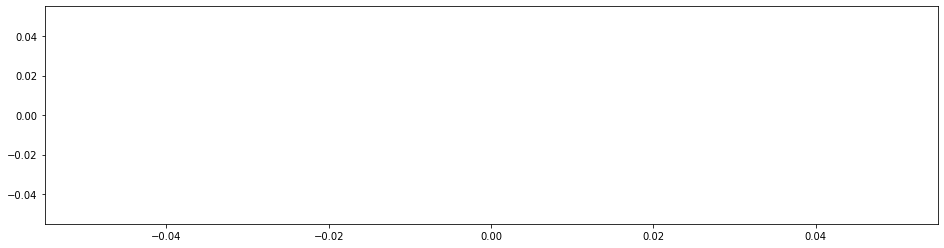

Episode * 2 * Moving Avg Reward is ==> 22.500 * Last Reward was ==> 22.000
Episode * 3 * Moving Avg Reward is ==> 20.667 * Last Reward was ==> 17.000
Episode * 4 * Moving Avg Reward is ==> 21.750 * Last Reward was ==> 25.000
Episode * 5 * Moving Avg Reward is ==> 22.400 * Last Reward was ==> 25.000
Episode * 6 * Moving Avg Reward is ==> 21.667 * Last Reward was ==> 18.000
Episode * 7 * Moving Avg Reward is ==> 25.143 * Last Reward was ==> 46.000
Episode * 8 * Moving Avg Reward is ==> 24.500 * Last Reward was ==> 20.000
Episode * 9 * Moving Avg Reward is ==> 23.444 * Last Reward was ==> 15.000
Episode * 10 * Moving Avg Reward is ==> 22.200 * Last Reward was ==> 11.000
Episode * 11 * Moving Avg Reward is ==> 22.818 * Last Reward was ==> 29.000
Episode * 50 * Moving Avg Reward is ==> 26.200 * Last Reward was ==> 77.000
Episode * 12 * Moving Avg Reward is ==> 26.750 * Last Reward was ==> 70.000
Episode * 13 * Moving Avg Reward is ==> 26.923 * Last Reward was ==> 29.000
Episode * 14 * Movin

In [12]:
from src.environments.discrete.cartpole import environment
agent = A3CAgent(environment, n_workers=1)
agent.learn(log_each_n_episodes=1)

In [8]:
#from src.environments.continuous.inverted_pendulum import environment
#agent = A2CAgent(environment)
#agent.learn()



In [15]:
agent.actor.prediiter(agent.env.reset())

Episode * 240 * Moving Avg Reward is ==> 150.080 * Last Reward was ==> 119.000
